Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import date, timedelta
from fbprophet import Prophet

In [25]:
#open datafile
with open('ultimate_data_challenge.json') as f:
  data = json.load(f)

In [27]:
data[0]

{'city': "King's Landing",
 'trips_in_first_30_days': 4,
 'signup_date': '2014-01-25',
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'surge_pct': 15.4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2,
 'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0}

In [28]:
len(data)

50000

In [310]:
#Convert to dataframe
df = pd.DataFrame(data)
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [311]:
#Check cities's name
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [508]:
#check the null values
df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
trip_days                 False
dtype: bool

In [509]:
#get data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
trip_days                 50000 non-null int64
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 4.6+ MB


In [510]:
#Calculate total active days 
df['trip_days'] = pd.to_datetime(df['last_trip_date']) - pd.to_datetime(df['signup_date']) + timedelta(days=1)
df['trip_days'] = df['trip_days'].dt.days
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,trip_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,144
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,97
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,171
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,132
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,2
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,112
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,2


It seems that the length of operation is related to the ratings, lower average rating of driver may cause driver inactive. 

Distance may be another factor too.

Let's take analysis to see if it is true.

In [511]:
#take columns of city, trip days, two ratings, sort by trip days
df_act = df[['city','trip_days','avg_rating_of_driver','avg_rating_by_driver','avg_dist','signup_date','last_trip_date']].sort_values('trip_days')
df_act.dropna()

,city,trip_days,avg_rating_of_driver,avg_rating_by_driver,avg_dist,signup_date,last_trip_date
37771,Winterfell,1,3.0,5.0,0.74,2014-01-10,2014-01-10
5002,Winterfell,1,5.0,5.0,3.07,2014-01-31,2014-01-31
5004,Winterfell,1,5.0,5.0,1.66,2014-01-08,2014-01-08
36099,Astapor,1,4.0,5.0,2.40,2014-01-25,2014-01-25
21191,Winterfell,1,5.0,2.5,5.72,2014-01-12,2014-01-12
...,...,...,...,...,...,...,...
21945,Winterfell,182,4.5,4.9,4.10,2014-01-01,2014-07-01
34464,King's Landing,182,4.7,4.7,3.00,2014-01-01,2014-07-01
39207,Winterfell,182,4.2,4.5,5.76,2014-01-01,2014-07-01
34959,Winterfell,182,4.8,5.0,2.27,2014-01-01,2014-07-01


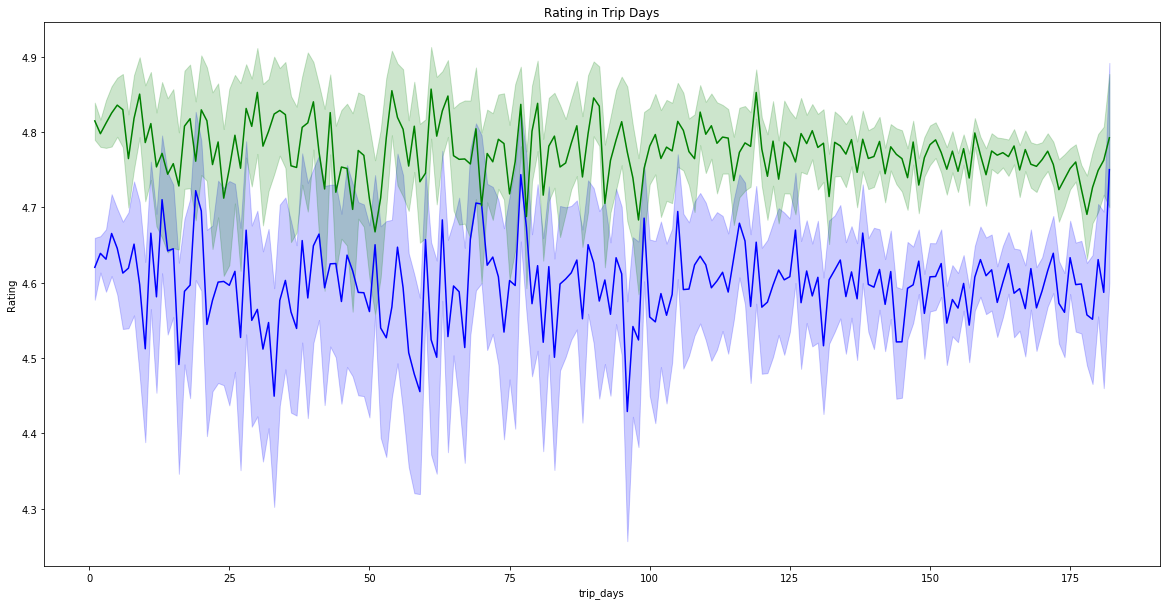

In [512]:
#draw two ratings changes with active days increase
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x = df_act['trip_days'], y = df_act['avg_rating_of_driver'], color = 'b')
sns.lineplot(x = df_act['trip_days'],  y = df_act['avg_rating_by_driver'], color = 'g')
plt.ylabel('Rating')
plt.title('Rating in Trip Days')
plt.show()

It can be seen from the figure that when the number of travel days is less than 100 days, the ratings of passengers (to the driver) fluctuate drastically. As the number of travel days increased, both ratings gradually stabilized between 4.5 and 4.9.

The difference between the driver's score and the passenger's score is also one of the influencing factors. The drivers used to give high rating to passengers, but passengers are strict. There is an extreme point at about day 90, driver gave 4.8, but passenger gave 4.2 or even lower than that. Such those kind of rating will suppress the driver’s passion and confidence, which may be the last grass for the driver to decide to end his career.

Let's see if the average distance is one of the influencing factors to cause long active days.

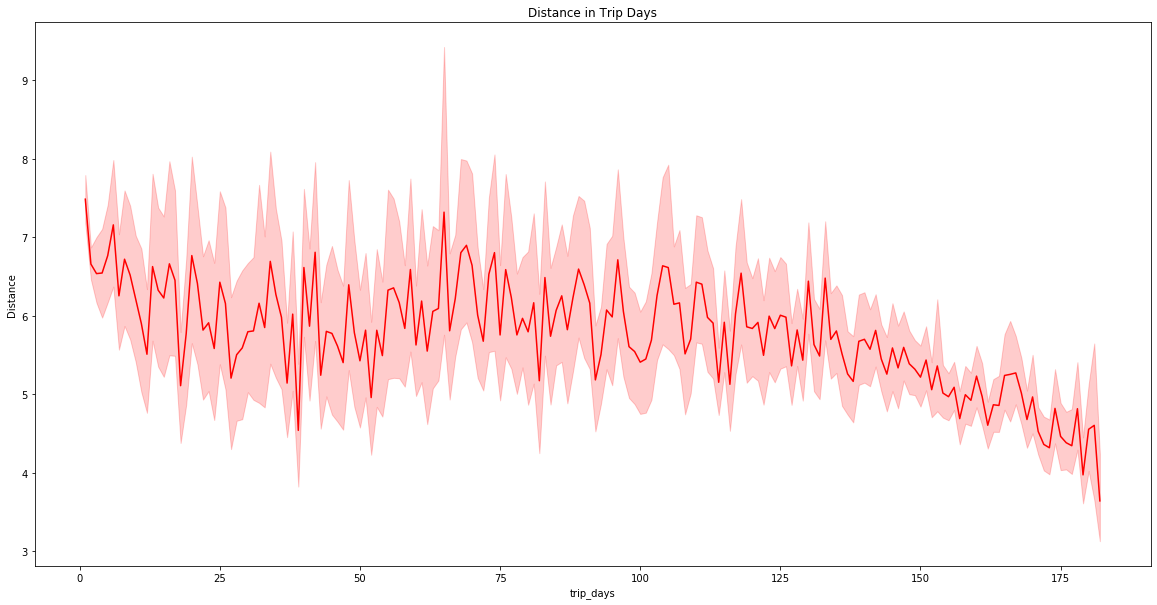

In [513]:
#draw average distance with active days increase
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x = df_act['trip_days'], y = df_act['avg_dist'], color = 'r')
plt.ylabel('Distance')
plt.title('Distance in Trip Days')
plt.show()

We can see at beginning, drivers are not care about the distance, but along with the trip days increase, they are perfer to take short trips. Or we can say, more short trips will push drivers active longer days. 
The short trip range is about 3.0 to 5.0.

How about drivers in different cities as a factor?

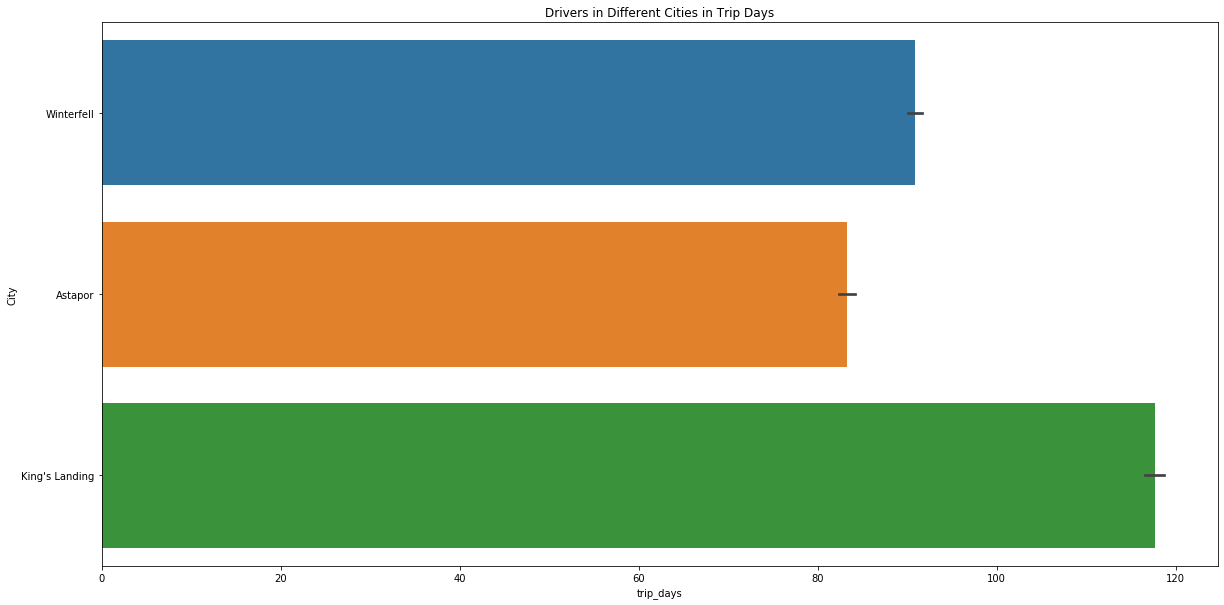

In [514]:
#draw average distance with active days increase
f, ax = plt.subplots(figsize=(20,10))
sns.barplot(x = df_act['trip_days'], y = df_act['city'])
plt.ylabel('City')
plt.title('Drivers in Different Cities in Trip Days')
plt.show()

Drivers in King's landing are longest active drivers, drivers in Winterfell are second, Astapor be the last one.
There are not big difference between three cities.

Next, I am going to build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Predictive model will base on time series.

In [572]:
#load data as time series
df_pre = df_act[['signup_date','trip_days','last_trip_date']]
df_pre.head()

,signup_date,trip_days,last_trip_date
37771,2014-01-10,1,2014-01-10
5002,2014-01-31,1,2014-01-31
5004,2014-01-08,1,2014-01-08
36099,2014-01-25,1,2014-01-25
21191,2014-01-12,1,2014-01-12


In [573]:
# Get counts of data before 100 days and after 180 days
df_pre['trip_days'] = df_pre['trip_days'].astype(int)
count_train = df_pre[df_pre['trip_days'] < 180].count()
count_test = df_pre[df_pre['trip_days'] > 180].count()
print(count_train, count_test)

signup_date       49772
trip_days         49772
last_trip_date    49772
dtype: int64 signup_date       85
trip_days         85
last_trip_date    85
dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [574]:
df_pre = df_pre.rename(columns={'signup_date':'ds', 'trip_days':'y'})
df_pre.tail()

,ds,y,last_trip_date
34464,2014-01-01,182,2014-07-01
39207,2014-01-01,182,2014-07-01
34959,2014-01-01,182,2014-07-01
23214,2014-01-01,182,2014-07-01
5706,2014-01-01,182,2014-07-01


In [575]:
#spilt data before and after 60 days 
df_train = df_pre[:49772]
df_test = df_pre[85:]
df_test

,ds,y,last_trip_date
43029,2014-01-03,1,2014-01-03
5429,2014-01-26,1,2014-01-26
43018,2014-01-31,1,2014-01-31
5122,2014-01-08,1,2014-01-08
47602,2014-01-19,1,2014-01-19
...,...,...,...
34464,2014-01-01,182,2014-07-01
39207,2014-01-01,182,2014-07-01
34959,2014-01-01,182,2014-07-01
23214,2014-01-01,182,2014-07-01


In [550]:
#Prophet 
p = Prophet()
p.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [551]:
#prediction
future = p.make_future_dataframe(periods=300)
p_forecast = p.predict(future)
p_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50067,2014-11-23,-110.228336,-893.460051,721.986365,-887.670751,709.934945,0.446058,0.446058,0.446058,0.446058,0.446058,0.446058,0.0,0.0,0.0,-109.782277
50068,2014-11-24,-110.885571,-897.205070,725.073943,-893.278018,712.532086,1.461485,1.461485,1.461485,1.461485,1.461485,1.461485,0.0,0.0,0.0,-109.424086
50069,2014-11-25,-111.542807,-899.082705,730.596234,-898.900550,715.963791,1.223683,1.223683,1.223683,1.223683,1.223683,1.223683,0.0,0.0,0.0,-110.319124
50070,2014-11-26,-112.200042,-911.963819,737.679948,-904.251815,719.386377,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,0.0,0.0,0.0,-112.293023
50071,2014-11-27,-112.857278,-931.100498,749.970173,-909.438015,721.644560,-1.347053,-1.347053,-1.347053,-1.347053,-1.347053,-1.347053,0.0,0.0,0.0,-114.204330


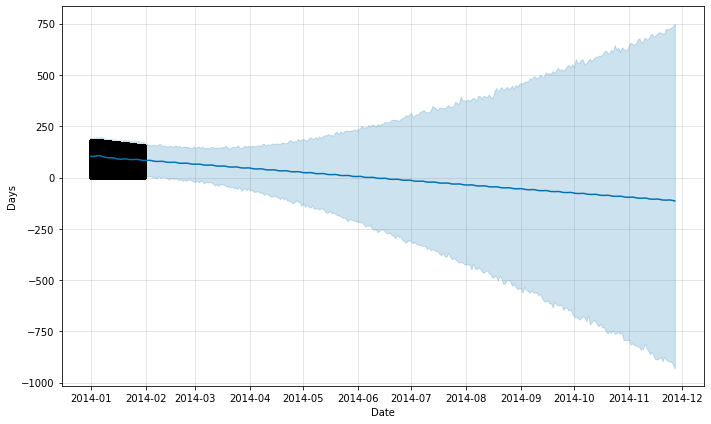

In [552]:
#Draw plot to show the forecasting result by prophet
figure = p.plot(p_forecast,xlabel='Date',ylabel='Days')

The figure shows if current driver has not actived over 180 days, he may not be in their 6 months. 

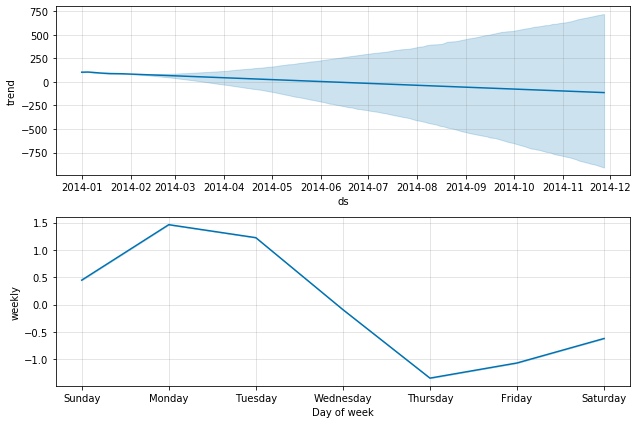

In [557]:
figure = p.plot_components(p_forecast)

##### Valuation

Take orginal data of lst_trip_Date as a valuation as below:

In [584]:
# #test data
df_test['ds']= df_test['last_trip_date']
 
# Make prediction and acutal days plot to compare
pred_test = p.predict(df_test)
pred_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,103.944068,26.000271,182.888504,103.944068,103.944068,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,0.0,0.0,0.0,103.851087
1,2014-01-01,103.944068,26.527138,179.453556,103.944068,103.944068,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,0.0,0.0,0.0,103.851087
2,2014-01-01,103.944068,26.665671,180.660018,103.944068,103.944068,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,0.0,0.0,0.0,103.851087
3,2014-01-01,103.944068,31.000897,183.775545,103.944068,103.944068,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,0.0,0.0,0.0,103.851087
4,2014-01-01,103.944068,23.055344,181.618824,103.944068,103.944068,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,-0.092981,0.0,0.0,0.0,103.851087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49910,2014-07-01,-14.929186,-300.671067,291.919832,-292.252490,272.440782,1.223683,1.223683,1.223683,1.223683,1.223683,1.223683,0.0,0.0,0.0,-13.705503
49911,2014-07-01,-14.929186,-297.134656,292.172205,-292.252490,272.440782,1.223683,1.223683,1.223683,1.223683,1.223683,1.223683,0.0,0.0,0.0,-13.705503
49912,2014-07-01,-14.929186,-290.276736,293.770211,-292.252490,272.440782,1.223683,1.223683,1.223683,1.223683,1.223683,1.223683,0.0,0.0,0.0,-13.705503
49913,2014-07-01,-14.929186,-299.023575,290.755068,-292.252490,272.440782,1.223683,1.223683,1.223683,1.223683,1.223683,1.223683,0.0,0.0,0.0,-13.705503


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


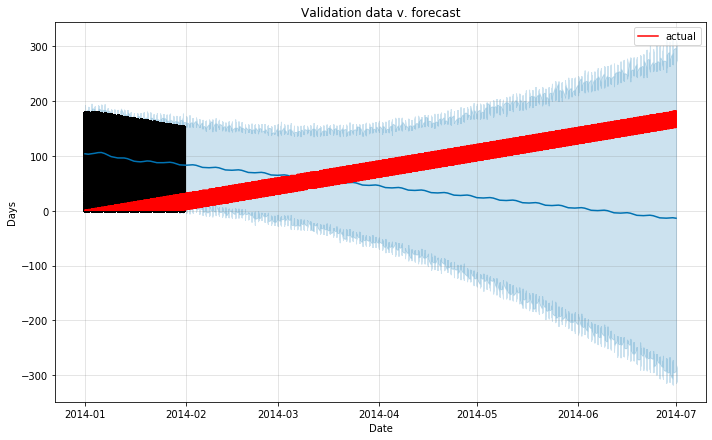

In [585]:
# Plot the model, forecast, and actual (test) data
df_test['ds'] = pd.to_datetime(df_test['ds'])

p.plot(pred_test, xlabel='Date',ylabel='Days')
plt.plot(df_test['ds'], df_test['y'], color='r', label='actual')
plt.title('Validation data v. forecast')
plt.legend();

The trend of prediction and actual shows if the drivers already actived over their 6 months, they will continue;  othervise, will not actived in their 6 months.

Ultimate can push pessengers to give a good ration to encounge driver to continue work, such like give some discount or coupon to passenger whom gave at least 4.5 rating to the driver.